### 1) Problem statement
- This project understands how the student's performance (test scores) is affected by other variables such as Gender, Ethnicity, Parental level of education, Lunch and Test preparation course.


### 2) Data Collection
- The data consists of 8 column and 1000 rows.


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [114]:
df = pd.read_csv('../dataset/StudentsPerformance.csv')

In [115]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


- We have 3 numerical features : ['math_score', 'reading_score', 'writing_score']
- We have 5 categorical features : ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']

In [116]:
df.shape

(1000, 8)

### 3. Data Checks to perform

- Missing values
- Duplicates
- data type
- Number of unique values in each column
- statistics of data set


In [117]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [118]:
df.duplicated().sum()

0

In [119]:
df.info

<bound method DataFrame.info of      gender race/ethnicity parental level of education         lunch  \
0    female        group B           bachelor's degree      standard   
1    female        group C                some college      standard   
2    female        group B             master's degree      standard   
3      male        group A          associate's degree  free/reduced   
4      male        group C                some college      standard   
..      ...            ...                         ...           ...   
995  female        group E             master's degree      standard   
996    male        group C                 high school  free/reduced   
997  female        group C                 high school  free/reduced   
998  female        group D                some college      standard   
999  female        group D                some college  free/reduced   

    test preparation course  math score  reading score  writing score  
0                      none    

In [120]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [121]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


#### Insight
- From above description we see, all means are very close to each other - between 66 and 68.05;
- All standard deviations are also close - between 14.6 and 15.19;
- While there is a minimum score  0 for math, for writing minimum is much higher = 10 and for reading myet higher = 17

# EDA and Visualizations

In [122]:
# combining three scores to make an average score

df['Average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

In [123]:
df['Average_score']

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: Average_score, Length: 1000, dtype: float64

**Target Variable Distribution - Average_Score**

The distribution of average scores is slightly left-skewed, indicating most students scored moderately well, with fewer very low scores.

Text(0.5, 1.0, 'Distribution of Average Student Score')

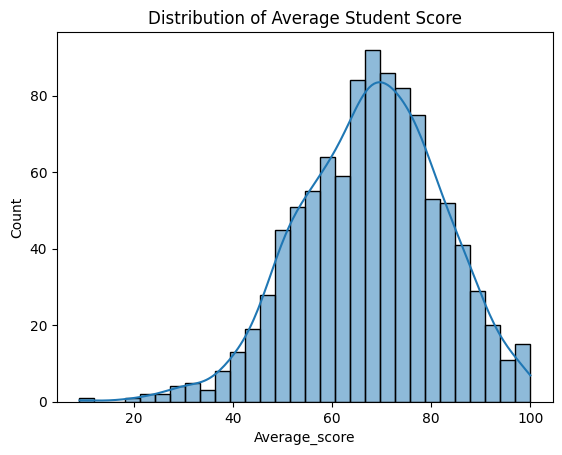

In [124]:
sns.histplot(df['Average_score'], bins=30, kde=True)
plt.title("Distribution of Average Student Score")


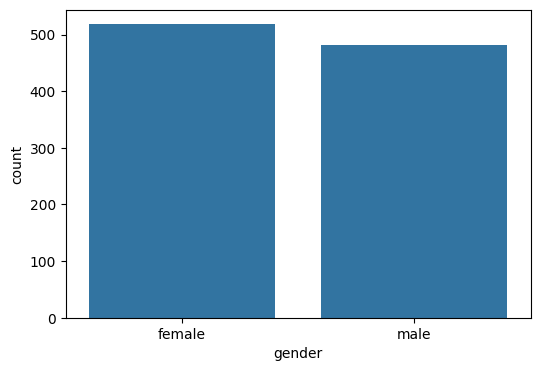

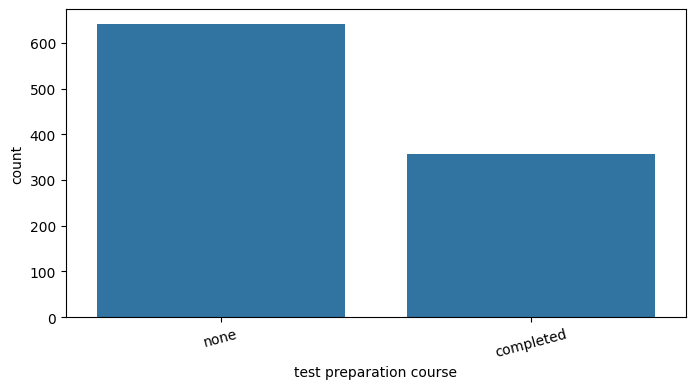

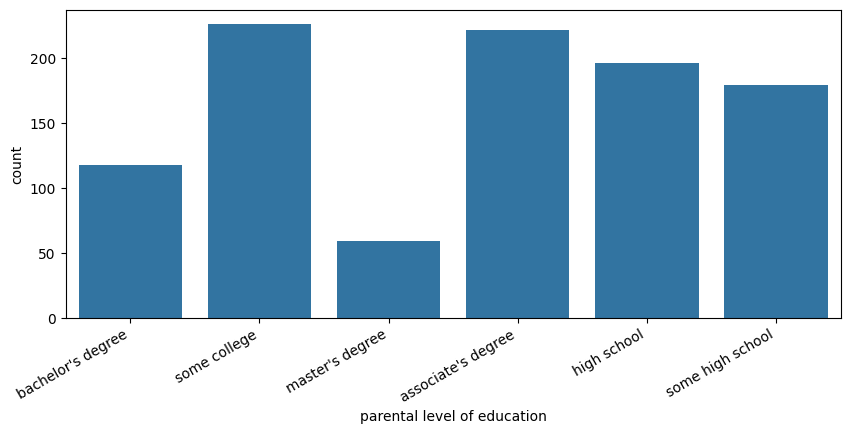

In [125]:
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.xticks(rotation=0) 
plt.show()

# Second plot
plt.figure(figsize=(8, 4))
sns.countplot(x='test preparation course', data=df)
plt.xticks(rotation=15)
plt.show()

# Third plot
plt.figure(figsize=(10, 4))
sns.countplot(x='parental level of education', data=df)
plt.xticks(rotation=30, ha='right')
plt.show()

- The dataset has a fairly balanced distribution of male and female students
- A majority of students did not complete the test preparation course
- Most parents had education levels around high school , associate's degree or some college


<Axes: xlabel='gender', ylabel='Average_score'>

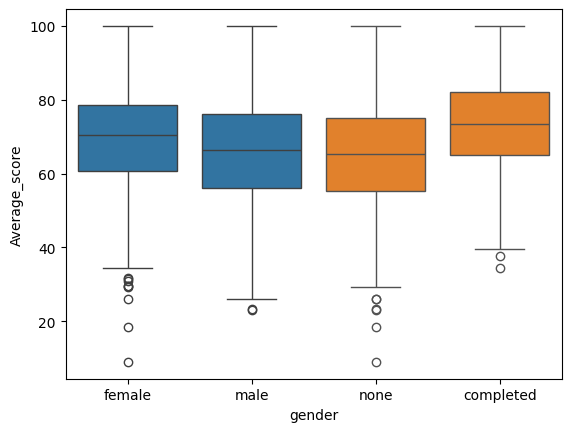

In [126]:


sns.boxplot(x='gender', y='Average_score', data=df)
sns.boxplot(x='test preparation course', y='Average_score', data=df)


**boxplot** 

- On average, female students tend to score slightly higher than male students.
- Students who completed the test preparation course performed better on average, indicating that the course has a positive impact on performance.


Text(0.5, 1.0, 'Avg Score by Parental Education')

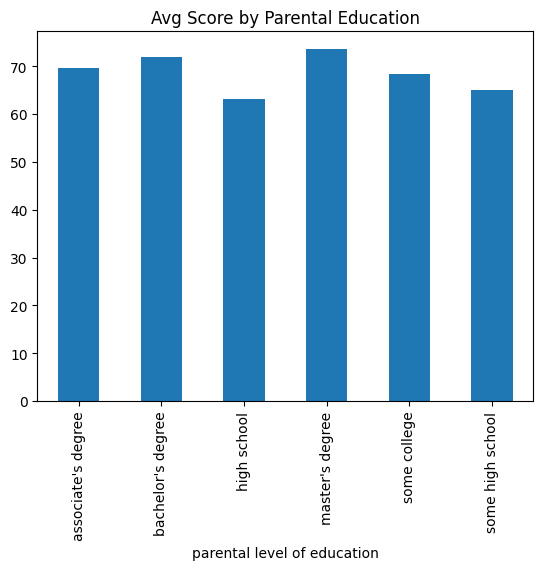

In [127]:


df.groupby('parental level of education')['Average_score'].mean().plot(kind='bar')
plt.title("Avg Score by Parental Education")


**Grouped Bar Charts**

Students whose parents had higher levels of education (like Bachelor's or Master's degrees) generally performed better.

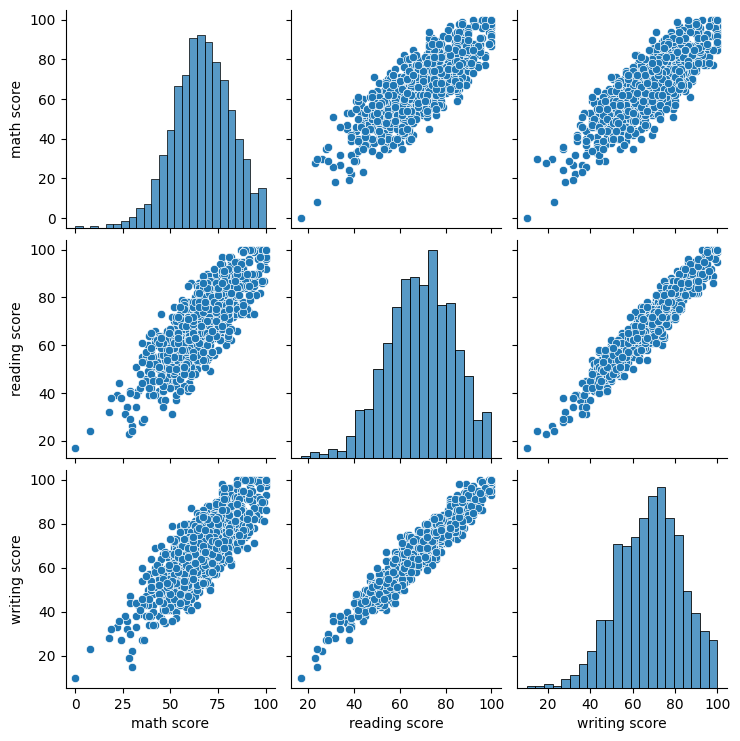

In [128]:
sns.pairplot(df[['math score', 'reading score', 'writing score']])


**Pairplot of Subject Scores**

There's a clear linear relationship between reading and writing scores

In [129]:
df.nunique()

gender                           2
race/ethnicity                   5
parental level of education      6
lunch                            2
test preparation course          2
math score                      81
reading score                   72
writing score                   77
Average_score                  194
dtype: int64

In [130]:
# gender and lunch - binary encoding

df['gender'] = df['gender'].map({
    "female" : 0,
    "male" : 1
})

df['lunch'] = df['lunch'].map({
    "free/reduced" : 0,
    "standard" : 1
})

# test preparation - binary ordinal encoding
df['test preparation course'] = df['test preparation course'].map({
    "none": 0,
    "completed" : 1
})

Applied binary encoding to variables like gender, lunch, and test preparation course as they contain only two categories. This simplifies the data while preserving meaning and ensures compatibility with ML models that require numerical input.

In [131]:

from sklearn.preprocessing import OrdinalEncoder

categ = [['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]]
edu_cat = OrdinalEncoder(categories=categ)
df[['parental level of education']] = edu_cat.fit_transform(df[['parental level of education']])
df['parental level of education'] = df['parental level of education'].astype(int)


In [132]:
# race / Ethnicity - no relation, no one is greater than other. - one hot encoding

df = pd.get_dummies(df,columns = ['race/ethnicity'], drop_first = True)



In [133]:
df.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,Average_score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,0,4,1,0,72,72,74,72.666667,True,False,False,False
1,0,2,1,1,69,90,88,82.333333,False,True,False,False
2,0,5,1,0,90,95,93,92.666667,True,False,False,False
3,1,3,0,0,47,57,44,49.333333,False,False,False,False
4,1,2,1,0,76,78,75,76.333333,False,True,False,False


In [134]:
df.dtypes

gender                           int64
parental level of education      int32
lunch                            int64
test preparation course          int64
math score                       int64
reading score                    int64
writing score                    int64
Average_score                  float64
race/ethnicity_group B            bool
race/ethnicity_group C            bool
race/ethnicity_group D            bool
race/ethnicity_group E            bool
dtype: object

In [135]:
## converting to 0 and 1 values in group b,c,d,e

df = df.astype({
    col:'int' for col in df.columns
    if df[col].dtype == 'bool'
})

In [136]:
# final cleaned data 
df.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,Average_score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,0,4,1,0,72,72,74,72.666667,1,0,0,0
1,0,2,1,1,69,90,88,82.333333,0,1,0,0
2,0,5,1,0,90,95,93,92.666667,1,0,0,0
3,1,3,0,0,47,57,44,49.333333,0,0,0,0
4,1,2,1,0,76,78,75,76.333333,0,1,0,0


In [137]:
# dropping avg score to prevent data leakage while predicting maths score 

df = df.drop(columns=['Average_score'])


In [139]:
df.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,0,4,1,0,72,0.193999,0.391492,1,0,0,0
1,0,2,1,1,69,1.427476,1.313269,0,1,0,0
2,0,5,1,0,90,1.770109,1.642475,1,0,0,0
3,1,3,0,0,47,-0.833899,-1.583744,0,0,0,0
4,1,2,1,0,76,0.605158,0.457333,0,1,0,0


# Supervised Learning - Linear Regression



Train Test Split

In [ ]:
# feature selection
X = df.drop(columns=['math score'])
y = df['math score']


#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Standardization

In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [143]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

In [144]:
from sklearn.metrics import mean_squared_error,r2_score

y_pred = model.predict(X_test_scaled)
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R2 Score: 0.8815597679452445
Mean Squared Error: 28.82105656383291


In [145]:
result = pd.DataFrame({
    'Actual' : y_test,
    'Predicted' : y_pred
})
print(result.head(10))

     Actual  Predicted
521      91  76.385804
737      53  58.255761
740      80  77.288737
660      74  76.288104
411      84  87.053863
678      81  79.004786
626      69  64.595691
513      54  53.492522
859      87  74.201340
136      51  49.707298


## Final Conclusion

### Supervised Learning (Regression)
- Built a linear regression model to predict the average score of students based on features like gender, lunch type, test preparation, and parental education.
- Model R² Score: ~0.88 — indicates that the features in this dataset explain ~88% of the variation in performance.
- While not highly accurate, this highlights the complexity of academic performance prediction hows how external features (like study time, attendance, etc.) might be missing.


